# MLP Classification (Heart Disease)

### **Bagian 1: Persiapan Data**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time

**Import library** yang digunakan dalam preprocessing data, training model, dan evaluasi menggunakan PyTorch.

In [2]:
data = pd.read_csv('/content/heart.csv')
print("Dataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Dataset Description:
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.6956

**Load dataset** `heart.csv` dan tampilkan informasi terkait struktur data, deskripsi statistik, dan jumlah missing values.

In [3]:
if data.isnull().sum().sum() > 0:
    data = data.dropna()  # Drop rows with missing values

Cek dan **hapus baris yang memiliki missing values** jika ada.

In [4]:
X = data.drop('target', axis=1).values  # Assuming 'target' is the column for classification
y = data['target'].values

Pisahkan dataset menjadi **fitur (X)** dan **label target (y)**.

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Lakukan **standardisasi fitur** agar memiliki mean = 0 dan standard deviation = 1.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Split data** menjadi train dan test set dengan proporsi 80:20.



### **Bagian 2: Dataset Custom Class**

In [7]:
# Create custom Dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Kelas ini mengimplementasikan PyTorch `Dataset` untuk **mengelola input dan label** dalam bentuk tensor.

### **Bagian 3: Model MLP dengan Dropout, BatchNorm, dan Regularisasi**


In [8]:
# Define the MLP model class with Dropout, BatchNorm, L1/L2 regularization
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, dropout_rate):
        super(MLPModel, self).__init__()
        layers = []
        for i, hidden_size in enumerate(hidden_layers):
            layers.append(nn.Linear(input_size if i == 0 else hidden_layers[i-1], hidden_size))  # Fully connected layer
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization layer
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'linear':
                layers.append(nn.Identity())  # Linear activation
            elif activation_fn == 'softmax':
                layers.append(nn.Softmax(dim=1))
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
        layers.append(nn.Linear(hidden_layers[-1], 2))  # Output layer with 2 classes
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Forward pass

MLP Model dengan:
  - **Fully connected layers** dan **BatchNorm** di setiap layer.
  - **Activation functions**: ReLU, Sigmoid, Tanh, Linear, atau Softmax.
  - **Dropout** sebagai regularisasi.


### **Bagian 4: Fungsi Training dan Evaluasi**

In [ ]:
# Define function to train and evaluate the model with L1/L2 regularization
def train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs, dropout_rate, weight_decay):
    # Initialize dataset and dataloaders
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPModel(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization via weight_decay

    # Print parameters being used
    print(f"\nTraining with Parameters: Hidden Layers={hidden_layers}, Activation={activation_fn}, LR={learning_rate}, Batch Size={batch_size}, Epochs={epochs}, Dropout={dropout_rate}, L2={weight_decay}")

    # Training loop
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Time: {epoch_time:.2f}s")

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

- **Load data** ke dalam PyTorch `DataLoader`.
- **DataLoader** digunakan untuk memuat data secara batch.
- Menginisialisasi model, loss function (CrossEntropyLoss), dan optimizer (Adam dengan weight decay untuk L2 regularisasi).
-  **Training loop**:
  - Forward pass → Hitung loss → Backward pass → Update parameter.
- **Evaluasi model**: Hitung akurasi pada data uji.


### **Bagian 5: Eksperimen**

#### **Eksperimen 1: Hidden Layers**


In [ ]:
# Experiment 1: Comparing Hidden Layers and Neurons
hidden_layers_options = [[4], [8], [16], [32], [64], [4, 4], [8, 8], [16, 16], [32, 16, 8]]  # Fixed to avoid nested lists
results_hidden_layers = []
for hidden_layers in hidden_layers_options:
    accuracy = train_and_evaluate(hidden_layers, activation_fn='relu', learning_rate=0.01, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_hidden_layers.append({'hidden_layers': hidden_layers, 'accuracy': accuracy})


Training with Parameters: Hidden Layers=[4], Activation=relu, LR=0.01, Batch Size=32, Epochs=50, Dropout=0.2, L2=0.0001
Epoch [1/50], Loss: 0.6403, Time: 0.27s
Epoch [2/50], Loss: 0.4591, Time: 0.25s
Epoch [3/50], Loss: 0.4033, Time: 0.26s
Epoch [4/50], Loss: 0.3671, Time: 0.26s
Epoch [5/50], Loss: 0.3794, Time: 0.27s
Epoch [6/50], Loss: 0.3761, Time: 0.26s
Epoch [7/50], Loss: 0.3624, Time: 0.26s
Epoch [8/50], Loss: 0.3687, Time: 0.28s
Epoch [9/50], Loss: 0.3595, Time: 0.27s
Epoch [10/50], Loss: 0.3696, Time: 0.27s
Epoch [11/50], Loss: 0.3327, Time: 0.27s
Epoch [12/50], Loss: 0.3630, Time: 0.28s
Epoch [13/50], Loss: 0.3507, Time: 0.28s
Epoch [14/50], Loss: 0.3666, Time: 0.27s
Epoch [15/50], Loss: 0.3481, Time: 0.25s
Epoch [16/50], Loss: 0.3502, Time: 0.25s
Epoch [17/50], Loss: 0.3403, Time: 0.24s
Epoch [18/50], Loss: 0.3501, Time: 0.25s
Epoch [19/50], Loss: 0.3430, Time: 0.25s
Epoch [20/50], Loss: 0.3335, Time: 0.25s
Epoch [21/50], Loss: 0.3411, Time: 0.25s
Epoch [22/50], Loss: 0.3344

 Bandingkan jumlah hidden layers dan jumlah neuron.



#### **Eksperimen 2: Activation Functions**


In [ ]:
# Experiment 2: Comparing Activation Functions
activation_functions = ['linear', 'sigmoid', 'relu', 'softmax', 'tanh']
results_activation_functions = []
for activation_fn in activation_functions:
    accuracy = train_and_evaluate(hidden_layers=[32], activation_fn=activation_fn, learning_rate=0.01, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_activation_functions.append({'activation_function': activation_fn, 'accuracy': accuracy})



Training with Parameters: Hidden Layers=[32], Activation=linear, LR=0.01, Batch Size=32, Epochs=50, Dropout=0.2, L2=0.0001
Epoch [1/50], Loss: 0.4222, Time: 0.28s
Epoch [2/50], Loss: 0.3719, Time: 0.28s
Epoch [3/50], Loss: 0.3800, Time: 0.27s
Epoch [4/50], Loss: 0.3533, Time: 0.27s
Epoch [5/50], Loss: 0.3550, Time: 0.27s
Epoch [6/50], Loss: 0.3539, Time: 0.27s
Epoch [7/50], Loss: 0.3600, Time: 0.28s
Epoch [8/50], Loss: 0.3537, Time: 0.27s
Epoch [9/50], Loss: 0.3639, Time: 0.28s
Epoch [10/50], Loss: 0.3494, Time: 0.27s
Epoch [11/50], Loss: 0.3579, Time: 0.28s
Epoch [12/50], Loss: 0.3631, Time: 0.27s
Epoch [13/50], Loss: 0.3674, Time: 0.28s
Epoch [14/50], Loss: 0.3594, Time: 0.27s
Epoch [15/50], Loss: 0.3697, Time: 0.27s
Epoch [16/50], Loss: 0.3712, Time: 0.28s
Epoch [17/50], Loss: 0.3579, Time: 0.27s
Epoch [18/50], Loss: 0.3663, Time: 0.26s
Epoch [19/50], Loss: 0.3503, Time: 0.27s
Epoch [20/50], Loss: 0.3750, Time: 0.27s
Epoch [21/50], Loss: 0.3540, Time: 0.27s
Epoch [22/50], Loss: 0.3

Bandingkan berbagai fungsi aktivasi.


#### **Eksperimen 3: Epochs**


In [ ]:
# Experiment 3: Comparing Epochs
epochs_options = [1, 10, 25, 50, 100, 250]
results_epochs = []
for epochs in epochs_options:
    accuracy = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=0.01, batch_size=32, epochs=epochs, dropout_rate=0.2, weight_decay=1e-4)
    results_epochs.append({'epochs': epochs, 'accuracy': accuracy})



Training with Parameters: Hidden Layers=[32], Activation=relu, LR=0.01, Batch Size=32, Epochs=1, Dropout=0.2, L2=0.0001
Epoch [1/1], Loss: 0.4613, Time: 0.31s

Training with Parameters: Hidden Layers=[32], Activation=relu, LR=0.01, Batch Size=32, Epochs=10, Dropout=0.2, L2=0.0001
Epoch [1/10], Loss: 0.4383, Time: 0.33s
Epoch [2/10], Loss: 0.3378, Time: 0.29s
Epoch [3/10], Loss: 0.3148, Time: 0.29s
Epoch [4/10], Loss: 0.2849, Time: 0.31s
Epoch [5/10], Loss: 0.2669, Time: 0.29s
Epoch [6/10], Loss: 0.2815, Time: 0.29s
Epoch [7/10], Loss: 0.2670, Time: 0.30s
Epoch [8/10], Loss: 0.2832, Time: 0.30s
Epoch [9/10], Loss: 0.2750, Time: 0.29s
Epoch [10/10], Loss: 0.2394, Time: 0.29s

Training with Parameters: Hidden Layers=[32], Activation=relu, LR=0.01, Batch Size=32, Epochs=25, Dropout=0.2, L2=0.0001
Epoch [1/25], Loss: 0.4080, Time: 0.30s
Epoch [2/25], Loss: 0.3285, Time: 0.30s
Epoch [3/25], Loss: 0.3065, Time: 0.30s
Epoch [4/25], Loss: 0.3202, Time: 0.30s
Epoch [5/25], Loss: 0.3040, Time: 0

Bandingkan jumlah epochs.

#### **Eksperimen 4: Learning Rates**


In [ ]:
# Experiment 4: Comparing Learning Rates
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
results_learning_rates = []
for learning_rate in learning_rates:
    accuracy = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=learning_rate, batch_size=32, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_learning_rates.append({'learning_rate': learning_rate, 'accuracy': accuracy})



Training with Parameters: Hidden Layers=[32], Activation=relu, LR=10, Batch Size=32, Epochs=50, Dropout=0.2, L2=0.0001
Epoch [1/50], Loss: 144.4288, Time: 0.32s
Epoch [2/50], Loss: 4.2785, Time: 0.33s
Epoch [3/50], Loss: 3.4302, Time: 0.33s
Epoch [4/50], Loss: 1.4975, Time: 0.31s
Epoch [5/50], Loss: 1.1183, Time: 0.34s
Epoch [6/50], Loss: 0.8256, Time: 0.32s
Epoch [7/50], Loss: 2.1389, Time: 0.33s
Epoch [8/50], Loss: 1.0431, Time: 0.31s
Epoch [9/50], Loss: 1.2356, Time: 0.32s
Epoch [10/50], Loss: 0.9683, Time: 0.32s
Epoch [11/50], Loss: 1.2001, Time: 0.31s
Epoch [12/50], Loss: 1.3447, Time: 0.31s
Epoch [13/50], Loss: 0.8785, Time: 0.31s
Epoch [14/50], Loss: 0.9395, Time: 0.31s
Epoch [15/50], Loss: 0.8189, Time: 0.32s
Epoch [16/50], Loss: 1.0372, Time: 0.30s
Epoch [17/50], Loss: 0.9439, Time: 0.31s
Epoch [18/50], Loss: 5.3227, Time: 0.31s
Epoch [19/50], Loss: 3.1160, Time: 0.31s
Epoch [20/50], Loss: 0.7962, Time: 0.31s
Epoch [21/50], Loss: 0.7717, Time: 0.31s
Epoch [22/50], Loss: 0.850

Bandingkan learning rate.


#### **Eksperimen 5: Batch Sizes**

In [ ]:
# Experiment 5: Comparing Batch Sizes
batch_sizes = [16, 32, 64, 128, 256, 512]
results_batch_sizes = []
for batch_size in batch_sizes:
    accuracy = train_and_evaluate(hidden_layers=[32], activation_fn='relu', learning_rate=0.01, batch_size=batch_size, epochs=50, dropout_rate=0.2, weight_decay=1e-4)
    results_batch_sizes.append({'batch_size': batch_size, 'accuracy': accuracy})



Training with Parameters: Hidden Layers=[32], Activation=relu, LR=0.01, Batch Size=16, Epochs=50, Dropout=0.2, L2=0.0001
Epoch [1/50], Loss: 0.4045, Time: 0.38s
Epoch [2/50], Loss: 0.3630, Time: 0.40s
Epoch [3/50], Loss: 0.3428, Time: 0.38s
Epoch [4/50], Loss: 0.3474, Time: 0.38s
Epoch [5/50], Loss: 0.3545, Time: 0.38s
Epoch [6/50], Loss: 0.3338, Time: 0.38s
Epoch [7/50], Loss: 0.3235, Time: 0.39s
Epoch [8/50], Loss: 0.2881, Time: 0.38s
Epoch [9/50], Loss: 0.3243, Time: 0.37s
Epoch [10/50], Loss: 0.3513, Time: 0.39s
Epoch [11/50], Loss: 0.2565, Time: 0.39s
Epoch [12/50], Loss: 0.2971, Time: 0.38s
Epoch [13/50], Loss: 0.2941, Time: 0.38s
Epoch [14/50], Loss: 0.2714, Time: 0.39s
Epoch [15/50], Loss: 0.2910, Time: 0.39s
Epoch [16/50], Loss: 0.2572, Time: 0.38s
Epoch [17/50], Loss: 0.2932, Time: 0.38s
Epoch [18/50], Loss: 0.2750, Time: 0.39s
Epoch [19/50], Loss: 0.2897, Time: 0.40s
Epoch [20/50], Loss: 0.2749, Time: 0.39s
Epoch [21/50], Loss: 0.2628, Time: 0.39s
Epoch [22/50], Loss: 0.244

 Bandingkan ukuran batch.

### **Simpan Hasil Eksperimen**


In [ ]:
# Save Results to CSV
hidden_layers_df = pd.DataFrame(results_hidden_layers)
activation_functions_df = pd.DataFrame(results_activation_functions)
epochs_df = pd.DataFrame(results_epochs)
learning_rates_df = pd.DataFrame(results_learning_rates)
batch_sizes_df = pd.DataFrame(results_batch_sizes)

hidden_layers_df.to_csv('mlp_hidden_layers_results.csv', index=False)
activation_functions_df.to_csv('mlp_activation_functions_results.csv', index=False)
epochs_df.to_csv('mlp_epochs_results.csv', index=False)
learning_rates_df.to_csv('mlp_learning_rates_results.csv', index=False)
batch_sizes_df.to_csv('mlp_batch_sizes_results.csv', index=False)

Simpan hasil eksperimen ke file CSV untuk analisis lebih lanjut.

### Model dengan HyperParameter Optimal

Epoch [1/150], Loss: 0.3912, Time: 0.48s
Epoch [2/150], Loss: 0.3343, Time: 0.21s
Epoch [3/150], Loss: 0.3287, Time: 0.19s
Epoch [4/150], Loss: 0.3250, Time: 0.19s
Epoch [5/150], Loss: 0.3177, Time: 0.21s
Epoch [6/150], Loss: 0.3113, Time: 0.19s
Epoch [7/150], Loss: 0.2887, Time: 0.19s
Epoch [8/150], Loss: 0.2692, Time: 0.20s
Epoch [9/150], Loss: 0.2873, Time: 0.20s
Epoch [10/150], Loss: 0.2850, Time: 0.20s
Epoch [11/150], Loss: 0.2481, Time: 0.21s
Epoch [12/150], Loss: 0.2621, Time: 0.20s
Epoch [13/150], Loss: 0.2496, Time: 0.20s
Epoch [14/150], Loss: 0.2316, Time: 0.19s
Epoch [15/150], Loss: 0.2253, Time: 0.20s
Epoch [16/150], Loss: 0.2606, Time: 0.20s
Epoch [17/150], Loss: 0.2288, Time: 0.20s
Epoch [18/150], Loss: 0.2100, Time: 0.20s
Epoch [19/150], Loss: 0.2131, Time: 0.20s
Epoch [20/150], Loss: 0.1990, Time: 0.21s
Epoch [21/150], Loss: 0.1978, Time: 0.19s
Epoch [22/150], Loss: 0.1918, Time: 0.20s
Epoch [23/150], Loss: 0.1718, Time: 0.20s
Epoch [24/150], Loss: 0.1785, Time: 0.20s
E

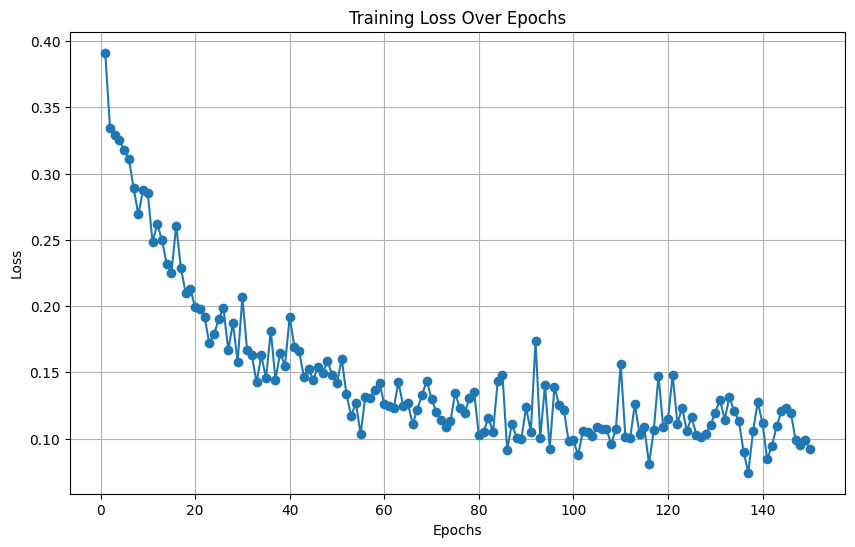

In [9]:
import matplotlib.pyplot as plt
# Define function to train and evaluate the model with L1/L2 regularization
def train_and_evaluate(hidden_layers, activation_fn, learning_rate, batch_size, epochs, dropout_rate, weight_decay):
    # Initialize dataset and dataloaders
    train_dataset = CustomDataset(X_train, y_train)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLPModel(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization via weight_decay

    # Training loop
    epoch_losses = []
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_time = time.time() - start_time
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy, epoch_losses

# Train model with optimal hyperparameters
optimal_params = {
    'hidden_layers': [32],
    'activation_fn': 'tanh',
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 150,
    'dropout_rate': 0.2,
    'weight_decay': 1e-4
}

accuracy, epoch_losses = train_and_evaluate(**optimal_params)

# Print final accuracy
print(f"\nFinal Model Accuracy with Optimal Hyperparameters: {accuracy:.2f}%")

# Visualize Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()